# Receipt Reader
## Using OCR and preprocessing image data with unsupervised clustering methods.

### Introduction

This has been a project I have wanted to do for some time. I have wanted to find time to build an app in which I take a photo of a receipt and then I am able to characterize the items I have spent into different categories and see how much I spent on different categories in the grocery store. The first part of this would of course be optical character recognition(OCR), which will be the focus of this notebook. Since many OCR techniques use neural nets, I think this falls into the category or unsupervised learning on its own, but I have also learned that many of the dimensionality reduction techniques that we learned in class are used to preprocess the image data before feeding it into the OCR model. 

I have opted to use kaggle for this project mainly for the reason of free compute. Kaggle also makes it very easy to upload data sets. I have hand currated a data set of receipts and hand labled one of them as well. This data set can be found here: https://www.kaggle.com/datasets/mattjburrill/receipt-pics/data

You can also find the code for this project here at my github: https://github.com/MJBurrill/CU_Boulder_MS_DS/tree/main/unsupervised_learning

In [1]:
pip install imutils

  Preparing metadata (setup.py) ... - \ done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=8d3438e4f3605b8070d923dc63aab6385932d89c980418b0741098aa1568fadd
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np 
import pandas as pd 
from imutils.perspective import four_point_transform
import pytesseract
import argparse
import imutils
import cv2
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from difflib import SequenceMatcher

## Data Collection and EDA:
I tried to find different images of reciepts that have different backgrounds and are from different retailers so that I could expierment and tweek my algorithm along the way. I also created a label df for one of the images. 

In [3]:
# list files in the custom data set of receipts I created. 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/receipt-pics/3526_labels.csv
/kaggle/input/receipt-pics/IMG_1270.png
/kaggle/input/receipt-pics/IMG_3525.png
/kaggle/input/receipt-pics/IMG_3525.jpeg
/kaggle/input/receipt-pics/img_6811-583x1024.jpg
/kaggle/input/receipt-pics/IMG_1097.png
/kaggle/input/receipt-pics/IMG_3526.png
/kaggle/input/receipt-pics/tjs.png
/kaggle/input/receipt-pics/sam_vit_h_4b8939.pth
/kaggle/input/receipt-pics/IMG_3526.jpeg
/kaggle/input/receipt-pics/WF-pic-2.jpg
/kaggle/input/receipt-pics/tjs.jpeg


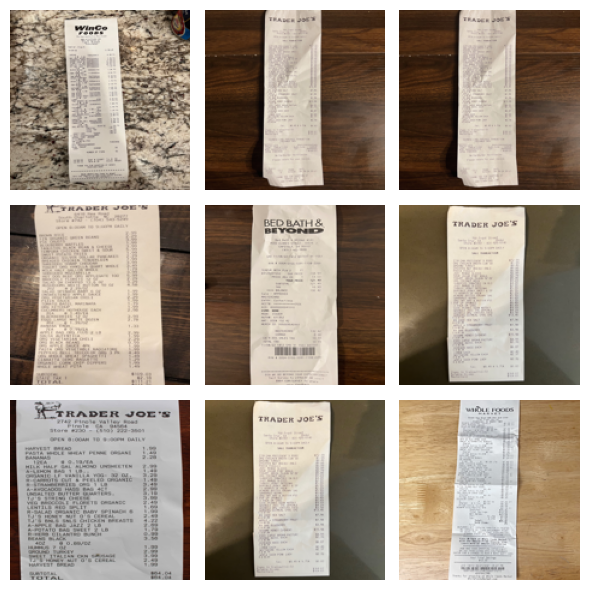

In [4]:
# create a grid of the images in the data set:

grid_size=(3, 3) 
image_size=(150, 150)

image_files = [f for f in os.listdir('/kaggle/input/receipt-pics/') if f.endswith(('jpg', 'jpeg', 'png', 'bmp'))]

fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(grid_size[1] * 2, grid_size[0] * 2))

for i, ax in enumerate(axes.flat):
    if i < len(image_files):
        
        img = Image.open(os.path.join('/kaggle/input/receipt-pics/', image_files[i]))
        img = img.resize(image_size)

        ax.imshow(img)
        ax.axis('off') 

    else:
        ax.axis('off')  

plt.tight_layout()
plt.show()

I also hand labeled one of the reciepts so that I would have some labels so that I could calculate some perfomance metrics.

In [5]:
labels_3526 = pd.read_csv('/kaggle/input/receipt-pics/3526_labels.csv')
print(labels_3526.head())

                Description  Quantity  Price
0  ITALIAN PRESIDENT'S RSRV         1  12.99
1  ORG CHICKEN BROTH LOW SO         1   1.99
2             GROUND TURKEY         1   4.49
3   CHICKEN NAT BREAST BNLS         1   9.88
4             PASTA FUSILLI         1   0.99


## First iteration: 
 - After going through this tutorial (https://pyimagesearch.com/2021/10/27/automatically-ocring-receipts-and-scans/) I implemted a more modularized version of their code. At first I was having a lot of trouble getting the pytesseract functions to work in reading any text. After much tinkering I realized that the width argument is really important. If its wrong, no text will be able to be read. 

In [6]:


def load_and_preprocess_image(image_path, width=800):
    orig = cv2.imread(image_path)
    image = imutils.resize(orig, width=width)
    ratio = orig.shape[1] / float(image.shape[1])
    
    return orig, image, ratio


def detect_edges(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5,), 0)
    edged = cv2.Canny(blurred, 75, 200)
    return edged


def find_receipt_contour(edged):
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            return approx
    raise Exception("Could not find receipt outline.")


def transform_image(orig, receiptCnt, ratio):
    receipt = four_point_transform(orig, receiptCnt.reshape(4, 2) * ratio)
    return receipt

# psm 4 Assume a single column of text of variable sizes.
# psm 5 Assume a single uniform block of vertically aligned text.
def perform_ocr(image):
    options = "--psm 4"
    text = pytesseract.image_to_string(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), config=options)
    return text


def extract_price_line_items(text):
    pricePattern = r'([0-9]+\.[0-9]+)'
    line_items = []
    for row in text.split("\n"):
        if re.search(pricePattern, row) is not None:
            line_items.append(row)
    return line_items


def line_items_to_dataframe(line_items):
    data = []
    for item in line_items:
        #regex
        price = re.search(r'\d+\.\d+', item).group()
        description = item.split(price)[0].strip()
        quantity = 1
        data.append({'Description': description, 'Quantity': quantity, 'Price': price})
    
    df = pd.DataFrame(data)
    return df


def process_receipt(image_path):
    orig, image, ratio = load_and_preprocess_image(image_path)
    edged = detect_edges(image)
    receiptCnt = find_receipt_contour(edged)
    receipt = transform_image(orig, receiptCnt, ratio)
    text = perform_ocr(receipt)
    line_items = extract_price_line_items(text)
    df = line_items_to_dataframe(line_items)
    
    return orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df

# Example usage
image_path = '/kaggle/input/receipt-pics/IMG_3526.png'
orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df_1 = process_receipt(image_path)

print(df_1)



                    Description  Quantity   Price
0   ITALIAN PRESIDENT 'S RORY $         1   12.94
1    ORG CHICKEN BROTH LOW 80 $         1    1.99
2               GROUND TURKEY $         1    4.49
3                  PASTA FUSILL         1    0.99
4           JUST MANGO SLICES $         1    2.99
5       SOUR CREAM PINT WHOLE $         1    2.79
6    YOGURT GREEK PLAIN 32 OZ $         1    5.49
7            ORG COCONUT MILK $         1    1.69
8           JUST MANGO SLICES $         1    2.99
9       TURKEY JERKY ORIGINAL $         1    5.99
10   BUFFALO JERKY SWEET & SP $         1    6.99
11          TJ HEARTS OF PALM $         1    2.29
12    AL MOND BUTE CREAMY SAL $         1    5.99
13             GARBANZO BEANS $         1    0.89
14             | POP UP SPONGES         1    8.49
15   GRANOLA JUST THE GRAINLE $         1    4.29
16    GRANOLA ORG TOASTED but $         1    3.99
17   soHAcRO OATMEAL CHOC CHI $         1   13.45
18           RX CHOC SEA SALT $         1    7.96


In [7]:
# I am curious what the full text looks like. It appears that the address is captured very nicely which could be useful for other applications.
print(text)

yy .  . ee ll al

TRADER JOE'S

700 Frant Street .
santa Cruz, CA 95060
Store #0193 ~ 831- 425-0140
OPEN 8:00AM TO 9:00PM DAILY

SALE TRANSACTION

ITALIAN PRESIDENT 'S RORY $12.94
ORG CHICKEN BROTH LOW 80 $1.99
GROUND TURKEY $4.49
CHICKEN NAT BREAST BNLS aa)
PASTA FUSILL 0.99
JUST MANGO SLICES $2.99
SOUR CREAM PINT WHOLE $2.79
YOGURT GREEK PLAIN 32 OZ $5.49
ORG COCONUT MILK $1.69
SUNDRIED TOMATOES IN GLI $4,49
JUST MANGO SLICES $2.99
TURKEY JERKY ORIGINAL $5.99
BUFFALO JERKY SWEET & SP $6.99
TJ HEARTS OF PALM $2.29
AL MOND BUTE CREAMY SAL $5.99
GARBANZO BEANS $0.89

ORG SW BRD & BUTTER PIC eu
| POP UP SPONGES 8.49
3 PACK DK CHOC ie
SIDE PEANUT UDON NOODLE 4,99
GRANOLA JUST THE GRAINLE $4.29
GRANOLA ORG TOASTED but $3.99
soHAcRO OATMEAL CHOC CHI $13.45
RX CHOC SEA SALT $7.96
(PPLE : STRAWBERRY FRUIT $1.98
a Bag BLUEBERRY $3.98
SESANE HONEY CASHEWS $15.98
£608 TARGE BROWN PASTURE $4.99
ORANGE NAVEL EACH $1.78
AVOCADO HASS EACH $6.87

LEMON $0.49
cota "VELLOW EACH $2.37
PPLE Ah PINK LADY 

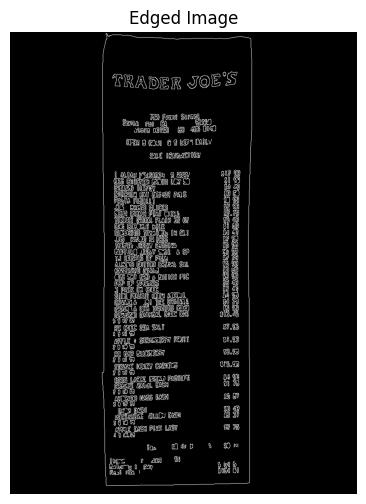

In [8]:
# display an image
def show_image(image, title="Image"):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()


show_image(edged, title="Edged Image")

### Performance Metrics

Since I created a labeled data set, I can now calcualte performance metrics. I am interested in both how often it gets words right, but I am also intersted in how often my algorithm gets the letters right. I think they are both important and indicate different things. 

In [9]:


def evaluate_ocr_performance(ocr_df, labels_df):

    ocr_df = ocr_df.reset_index(drop=True)
    labels_df = labels_df.reset_index(drop=True)

    ocr_values = []
    label_values = []


    for idx, label_row in labels_df.iterrows():
        if idx < len(ocr_df):
            ocr_row = ocr_df.iloc[idx]

            for col in labels_df.columns:
                ocr_value = ocr_row[col] if col in ocr_df.columns else None
                label_value = label_row[col]

                ocr_values.append(str(ocr_value))
                label_values.append(str(label_value))


    # word level accuracy
    accuracy = accuracy_score(label_values, ocr_values)
    
    # letter level accuracy
    def levenshtein_ratio(s1, s2):
        return SequenceMatcher(None, s1, s2).ratio()

    def average_levenshtein_accuracy(true_labels, predicted_labels):
        distances = [levenshtein_ratio(true, pred) for true, pred in zip(true_labels, predicted_labels)]
        return sum(distances) / len(distances)
    
    avg_leve_acc = average_levenshtein_accuracy(label_values, ocr_values)


    metrics = {
        "Accuracy": accuracy,
        "Average Levenshtein Accuracy":avg_leve_acc
    }

    return metrics


metrics_1 = evaluate_ocr_performance(df_1,labels_3526)
print(metrics_1)


{'Accuracy': 0.27956989247311825, 'Average Levenshtein Accuracy': 0.5365152983870692}


## Can we use any dimensionality reduction methods to make the reading better?
 - The idea here is that if we can use k means clustering to reduce the noise in the data, then the text will stand out better.

### K means clustering

In [10]:


from sklearn.cluster import KMeans

def kmeans_background_separation(image, k=2):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # convert back to 8-bit values and map labels to the center
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image



def process_receipt_kmeans(image_path):
    orig, image, ratio = load_and_preprocess_image(image_path)
    
    kmeans_image = kmeans_background_separation(image, k=3)
    
    edged = detect_edges(kmeans_image)
    receiptCnt = find_receipt_contour(edged)
    receipt = transform_image(orig, receiptCnt, ratio)
    text = perform_ocr(receipt)
    line_items = extract_price_line_items(text)
    df = line_items_to_dataframe(line_items)
    
    return orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df

image_path = '/kaggle/input/receipt-pics/IMG_3526.png'
orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df_2 = process_receipt_kmeans(image_path)

print(df_2)

                    Description  Quantity   Price
0    [TALTAN PRESTDENT'S RORY $         1   12.99
1    ORG CHICKEN BROTH LOW SO $         1    1.99
2               GROUND TURKEY $         1    4.49
3                 PASTA FUSILLI         1    0.99
4           JUST MANGO SLICES $         1    2.99
5       SQUR CREAM PINT WHOLE $         1    2.79
6    YOGURT GREEK PLAIN 32 02 $         1    5.49
7            ORG COCONUT MILK $         1    1.69
8           JUST MANGO SLICES $         1    2.99
9       TURKEY JERKY ORIGINAL $         1    5.99
10     BUFFALO JERKY SWEET & SP         1   86.99
11  ALMGHD, BUTTER CREAMY SAL $         1    5.99
12             GARBANZO BEANS $         1    0.89
13      SIDE PEANUT UBON NOODLE         1    4.99
14   RRANILA JUST THE GRATNLE $         1    4.29
15   GRANOLA ORG TOASTED COCO $         1    3.99
16    oHACRO QATMEAL CHOC CHI $         1   13.45
17           RX CHOC SEA SALT $         1    7.96
18   (PPLE : STRAWBERRY FRUIT $         1    1.98


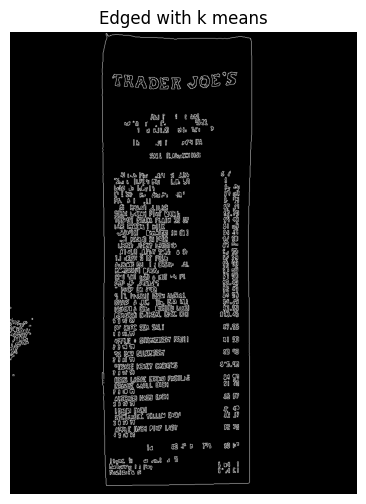

In [11]:
show_image(edged, title="Edged with k means")

In [12]:
metrics_2 = evaluate_ocr_performance(df_2,labels_3526)
print(metrics_2)

{'Accuracy': 0.2916666666666667, 'Average Levenshtein Accuracy': 0.5263895252812546}


Slight improvment with some k means clustering on the word average! Interestingly the Average Levenshtein Accuracy slightly worse. It also appears that the edged image has more defined boundaries, perhaps leading to better performance. 

### PCA:

In [13]:
from sklearn.decomposition import PCA

def pca_background_separation(image, n_components=3):

    pixel_values = image.reshape((-1, 3))
    
    # pca
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(pixel_values)
    
    restored_image = pca.inverse_transform(pca_result)
    
    restored_image = restored_image.reshape(image.shape)
    
    restored_image = np.clip(restored_image, 0, 255).astype('uint8')
    
    return restored_image

def process_receipt_pca(image_path):
    orig, image, ratio = load_and_preprocess_image(image_path)
    
    pca_image = pca_background_separation(image, n_components=3)

    edged = detect_edges(pca_image)
    receiptCnt = find_receipt_contour(edged)
    receipt = transform_image(orig, receiptCnt, ratio)
    text = perform_ocr(receipt)
    line_items = extract_price_line_items(text)
    df = line_items_to_dataframe(line_items)
    
    return orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df

# Example usage
image_path = '/kaggle/input/receipt-pics/IMG_3526.png'
orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df_pca = process_receipt_pca(image_path)

print(df_pca)

                   Description  Quantity   Price
0    [TALTAN PRESIDEN § RORY $         1   12.95
1              GROUND TURKEY $         1    4.49
2                PASTA FUSILLI         1    6.99
3          JUST MANGO SLICES $         1    2.99
4       SUR CREAM PINT WHOLE $         1    2.79
5   YOGURT GREEK PLAIN 32 0Z $         1    5.49
6           ORG COCONUT MILK $         1    1.69
7          JUST MANGO SLICES $         1    2.99
8     TURKEY JERKY. ORIGINAL $         1    5.99
9     BUFFALO JERKY SHEET & SP         1   86.99
10         TJ HEARTS OF PALM $         1    2.29
11  ALMOND BUTTER CREAMY SAL $         1    5.99
12            GARBANZO BEANS $         1    0.69
13            | POP uP SPONGES         1    8.49
14  GRANOLA JUST THE GRATNLE $         1    4.29
15  SoHACRO OATMEAL CHOC CHI $         1   13.45
16  (PPLE : STRAWBERRY FRUIT $         1    1.98
17           ni Ba BLUEBERRY $         1    3.98
18         ESA HONEY CASHEWS $         1   15.98
19         ORANGE NA

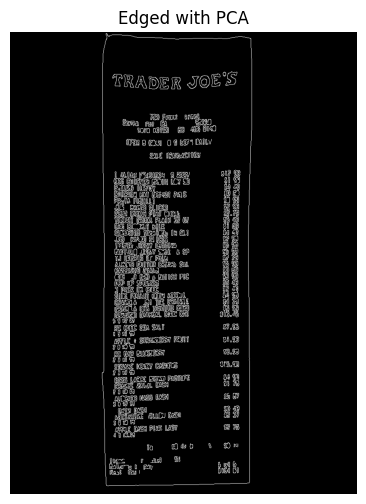

In [14]:
show_image(edged, title="Edged with PCA")

In [15]:
metrics_pca = evaluate_ocr_performance(df_pca,labels_3526)
print(metrics_pca)

{'Accuracy': 0.2839506172839506, 'Average Levenshtein Accuracy': 0.5066883549107466}


Looks like the accuracy is inbetween the intial implementation and the k means clustering. The edged image certainly looks worse than the one from kmeans.

## Segmentation experiment:

I figured there should be some overlap between what I am trying to do with reciepts and other kaggle projects, so I went looking for other image detection competitions and stumbled across this whale tail identification challenge. In particular I thought this notebook(https://www.kaggle.com/code/stpeteishii/whale-tail-segment-anything-create-mask) was interesting so I implemented something similar. 

In [16]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-qzwry9ns
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-qzwry9ns
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [17]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

def find_best_receipt_mask(masks):
    # This could use some work
    best_mask = masks[2]['segmentation']  
    return best_mask

# segment-anything
def segment_receipt(image):
    sam = sam_model_registry["vit_h"](checkpoint="/kaggle/input/receipt-pics/sam_vit_h_4b8939.pth")
    mask_generator = SamAutomaticMaskGenerator(sam)
    masks = mask_generator.generate(image)
    
    receipt_mask = find_best_receipt_mask(masks)
    
    receipt_mask = (receipt_mask * 255).astype("uint8")
    
    segmented_receipt = cv2.bitwise_and(image, image, mask=receipt_mask)
    
    return segmented_receipt



def process_receipt_with_segmentation(image_path):
    orig, image, ratio = load_and_preprocess_image(image_path)
    segmented_image = segment_receipt(image)
    edged = detect_edges(segmented_image)
    receiptCnt = find_receipt_contour(edged)
    receipt = transform_image(orig, receiptCnt, ratio)
    text = perform_ocr(receipt)
    line_items = extract_price_line_items(text)
    df = line_items_to_dataframe(line_items)
    
    return orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df


image_path = '/kaggle/input/receipt-pics/IMG_3526.png'
orig, image, ratio, edged, receiptCnt, receipt, text, line_items, df_3 = process_receipt_with_segmentation(image_path)

print(df_3)

                   Description  Quantity   Price
0   [TALTAN PRESIDENT'S RORY $         1   12.95
1   ORE CHICKEN BROTH LOW SO $         1    1.99
2              GROUND TURKEY $         1    4.49
3          JUST MANGO SLICES $         1    2.99
4      SAUR CREAM PINT WHOLE $         1    2.79
5           ORG COCONUT MILK $         1    1.69
6           UST MANGO SLICES $         1    2.99
7      TURKEY JERKY ORIGINAL $         1    5.99
8             GARBANZO BEANS £         1    0.89
9   ORG SHT BRD & BUTTER PIC $         1    3.99
10   SIDE PE cANUT UBON NOODLE         1    4.99
11   GRANOLA JUST. Ute GRAIN $         1    4.29
12   soHAcRO RS EAL CHOC CHI $         1   13.45
13           a Big BLUEBERRY $         1    3.98
14      SESANE HONEY CASHEWS $         1   15.98
15         ORANGE NAVEL EACH $         1    1.78
16         AVOCADO HASS EACH $         1    6.87
17                 TEMON ACH $         1    0.49
18                                     1     3.4
19      APPLE EACH P

In [18]:
metrics_3 = evaluate_ocr_performance(df_3,labels_3526)
print(metrics_3)

{'Accuracy': 0.3333333333333333, 'Average Levenshtein Accuracy': 0.6013788336970679}


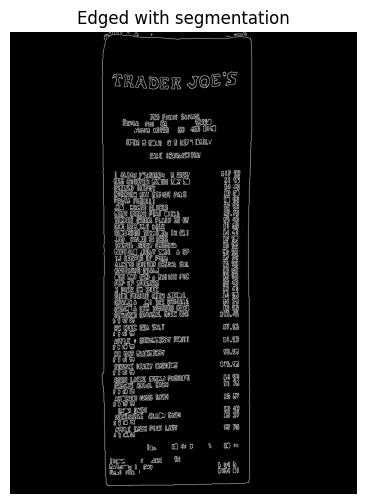

In [19]:
show_image(edged, title="Edged with segmentation")

One downside to this methodology is that it takes at least 5 minutes to run every time in comparison to the methods above with only take a hand full of seconds. Interestingly though, applying the mask gets the best performance. I think I could optimize this even further by making my mask selection algorthim better and finding ways to speed this up as well.

### Conclusions:
This was a fun project! I went into the project have no background in image analysis at all. I learned a lot about image processing for OCR and OCR in general. 

Some key take aways:
 - I think the accuracy numbers a artifically low because I was having a really hard time with the regex for the blank spaces that then indicate the quantity, so I auto filled with 1 for now. 
 - A lower than normal accuracy might be ok in this instance, because I may be able to do some post processing on the text that the OCR reads to clean it up. Some ideas could be fuzzy matching or using an LLM to predict what the description should be given the context from the OCR.